# Word2Vec

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

## Загрузка данных и подготовка корпуса

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7) # 70% train, 30% validation
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10])) # first ten strings

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [3]:
# токенизируем (внутри регулярка)
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

sour cream
ounces swordfish snapper other firm fleshed fish
tablespoon minced basil leaves
handful fresh parsley finely minced
ounces lard butter plus more brushing tops
green cardamom pods
stick pound unsalted butter softened
teaspoon pepper flakes preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallions thinly sliced


In [4]:
# строим словарь по обучающей выборке. 
# Убираем слишком редкие и слишком частые слова. 
# Токен 0 (выравнивания), чтобы объединить предложения разной длины
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2267
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('fresh', 8), ('tablespoon', 9)]


In [5]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent) for sent in train_token_ids[:10]))

222 52
22 878 574 127 246 707 181
9 19 88 33
517 8 43 15 19
22 586 20 45 47 649 648
59 329 535
200 12 50 20 266
2 5 140 78 1208 735 153 47 10
9 8 31 25
98 65 27


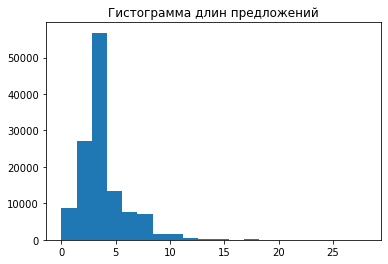

In [6]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [7]:
# Создаем датасеты для pytorch 
# PaddedSequenceDataset имеет метод len, может возвращать 
# предложение по номеру. При этом длинное предложение обрезает
# Короткому докидывает токенов <PAD>. Возвращает пару (текст,таргет)
MAX_SENTENCE_LEN = 20 # выбираем по гистограмме
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])
# Датасет будет переноситься на видеокарту батчами

(tensor([222,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$
Дальше используем метод максимального правдоподобия. То есть моделируем распределение соседних слов в окне при условии что мы пронаблюдали центральное слово (W, D параметры модели)
$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$
Произведение раскладывается на произвведение более простых распределений. Каждое такое "более простое" распределение нам говорит, насколько вероятно можно встретить какое-то контекстное слово рядом с центральным словом. То есть, для слов, которые типично встречаются рядом, наша модель должна возвращать вероятность, близкую к единице, а для слов, которые никогда не встречаются рядом — вероятность, близкую к нулю. В этом распределении у нас есть две случайные величины. Обе они — категориальные (то есть, дискретные и принимающие значение из некоторого фиксированного конечного набора).
$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
Общепринятый способ моделировать категориальные распределения — это софтмакс. Софтмакс — это функция такого вида, которой на вход подаётся вектор вещественных чисел из произвольного диапазона, и она переводит этот вектор в вектор, описывающий распределение вероятности категориальной величины. В контексте word2vec мы подаём в софтмакс оценки сходства слов. Сходство слов мы будем моделировать как скалярное произведение векторов этих слов. Причём мы будем, для центрального слова, брать векторы из первой матрицы (из матрицы w), а для контекстного слова мы будем брать вектор из второй матрицы (матрицы d).    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

Проблема заключается в том, что нам необходимо брать сумму в знаменателе по очень большому числу слагаемых. Это очень вычислительно неэффективно. Авторы модели предлагают заменить сумму по всему словарю суммой по небольшому количеству случайно выбранных слов и, каждый раз, когда нам нужно посчитать аппроксимацию к этому софтмаксу, мы выбираем новые случайные слова — это, как раз, называется "negative sampling".
  
Задача обучения word2vec сводится к обучению классификатора, который, имея два идентификатора слова (два номера токена) предсказывает — могут они встретиться вместе, или не могут.

In [8]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

**Negative Sampling** работает следующим образом - мы **максимизируем сумму вероятностей двух событий**: 

* "этот пример центрального слова вместе с контекстными словами взят **из тренировочной выборки**": $$ P(y=1 | CenterW_i; CtxW_j) = sigmoid(w_i \cdot d_j) = \frac{1}{1+e^{-w_i \cdot d_j}} $$

$$ \\ $$

* "этот пример центрального слова вместе со случайми контекстными словами **выдуман** ": $$ P(y=0 | CenterW_i; CtxW_{noise}) = 1 - P(y=1 | CenterW_i;  CtxW_{noise}) = \frac{1}{1+e^{w_i \cdot d_{noise}}} $$

$$ \\ $$

$$ NEG(CtxW_j, CenterW_i) = log(\frac{1}{1+e^{-w_i \cdot d_j}}) + \sum_{l=1}^{k}log(\frac{1}{1+e^{w_i \cdot d_{noise_l}}})  \rightarrow \max_{W,D} $$

In [9]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        # По умолчанию, nn.embedding заполняет значения в своей матрице
        # нормальным шумом. 
        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0) # таблица центр векторов
        # Правильный способ инициализации весов для word2vec — 
        # равномерный шум, причём его диапазон значений связан с 
        # размерностью эмбеддингов. 
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        # Такая инициализация нужна для того, чтобы длина вектора, 
        # начальная, примерно равнялась единице. 
        # Мы говорим слою nn embedding, что токен с индексом "0" (<PAD>)
        # — для него вектор всегда будет нулевым. 
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0) # таблица контекстных векторов      
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов
        Здесь для вычисления функции потерь"""
        batch_size = sentences.shape[0]
        # Получаем центральный эмбеддинг
        center_embeddings = self.center_emb(sentences)  # выход Batch x MaxSentLength x EmbSize

        # По сути обучение классификатор - могут ли два слова находиться рядом внутри окна
        # Делаем выборку из контекстных токенов
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        # Матричное произведение для каждой пары батчей в матрице. Вход-два батча матриц
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        # positive_sims - оценка сходства с настоящими соседними словами
        positive_probs = torch.sigmoid(positive_sims) # преобразуем в вероятности, что два слова встретятся вместе

        # Обрезаем матрицу по окну при помощи матрицы маски
        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова (в качестве отрицательных берем случайные в равномерном)
        # рандинт дает случайные номера токенов
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        # делаем выборку из таблицы контекстных векторов для полученных отрицательных токенов и сразу же её транспонируем.
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        # Оцениваем сементическое сходство, аналогичено как в положительных
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))
        # binary cross entropy with logits, вход принимает не оценки вероятностей, а оценки сходства, 
        # то есть не нормализованные значения. По сути, эти два способа использовать кросс-энтропию — 
        # примерно одинаковы, но второй более стабильный с численной точки зрения. 

        # Возвращаем сумму функции потерь для положительных примеров и для отрицательных.
        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [10]:
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)
                                          
# train_eval_loop стандартный цикл обучения НС
# learning rate динамически изменяется
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=10,
                                            batch_size=8,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 2.12 сек
Среднее значение функции потерь на обучении 0.8888517271453652
Среднее значение функции потерь на валидации 0.8810248535334487
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 1.83 сек
Среднее значение функции потерь на обучении 0.8782616498349965
Среднее значение функции потерь на валидации 0.8773735735457243
Новая лучшая модель!

Эпоха 2
Эпоха: 2001 итераций, 2.61 сек
Среднее значение функции потерь на обучении 0.8767202120015527
Среднее значение функции потерь на валидации 0.8763614479499527
Новая лучшая модель!

Эпоха 3
Эпоха: 2001 итераций, 2.23 сек
Среднее значение функции потерь на обучении 0.8759112343795296
Среднее значение функции потерь на валидации 0.8765574443189403

Эпоха 4
Эпоха: 2001 итераций, 2.48 сек
Среднее значение функции потерь на обучении 0.8760859334486714
Среднее значение функции потерь на валидации 0.8765440728357277
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.

Эпоха 5
Эпоха: 2001 итераций, 1.94 сек
С

In [11]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), './models/3.3.sgns.pth')

trainer.load_state_dict(torch.load('./models/3.3.sgns.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

In [12]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)
# класс embeddings берет массив эмбеддингов и словарь соответствия номер_токена:слово
# Каждый вектор нормируется на эвклидову норму
# Класс поддерживает методы - поиск ближайших слов, решение семантической пропорции (задача аналогии, то 
# есть одно слово относится к другому так же как третье относится к четвертому),
# получение списка векторов для слов, вычисление близовсти векторов (принимает вектор и возвращает список к-ближайших
# векторов)
embeddings.most_similar('chicken')

[('chicken', 0.9999325),
 ('turkey', 0.6199476),
 ('stock', 0.582512),
 ('boneless', 0.55194074),
 ('skinless', 0.5337725),
 ('breast', 0.5190015),
 ('broth', 0.5169594),
 ('thighs', 0.5077597),
 ('beef', 0.50631803),
 ('sodium', 0.49207687)]

In [13]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cacao', 1.0405878),
 ('cheese', 0.87062615),
 ('fromage', 0.6988515),
 ('goat', 0.6774183),
 ('provolone', 0.6630502),
 ('cassis', 0.6502125),
 ('fresco', 0.616708),
 ('crema', 0.6141557),
 ('pecorino', 0.60379845),
 ('shaving', 0.59313333)]

In [14]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


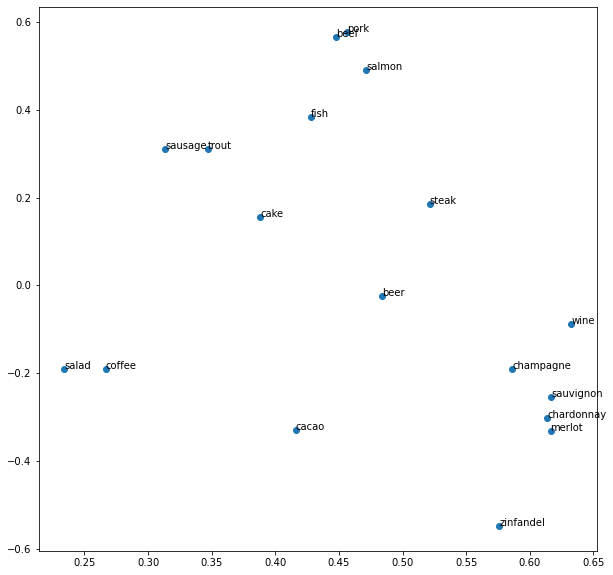

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [16]:
import gensim
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)
                                  
word2vec.wv.most_similar('chicken')

[('duck', 0.7208492755889893),
 ('thighs', 0.7034012079238892),
 ('simmering', 0.6967778205871582),
 ('turkey', 0.6862523555755615),
 ('pheasant', 0.6807904243469238),
 ('defatted', 0.6586886644363403),
 ('drumsticks', 0.6491477489471436),
 ('wings', 0.6475836038589478),
 ('breasts', 0.6457031965255737),
 ('magret', 0.6397683620452881)]

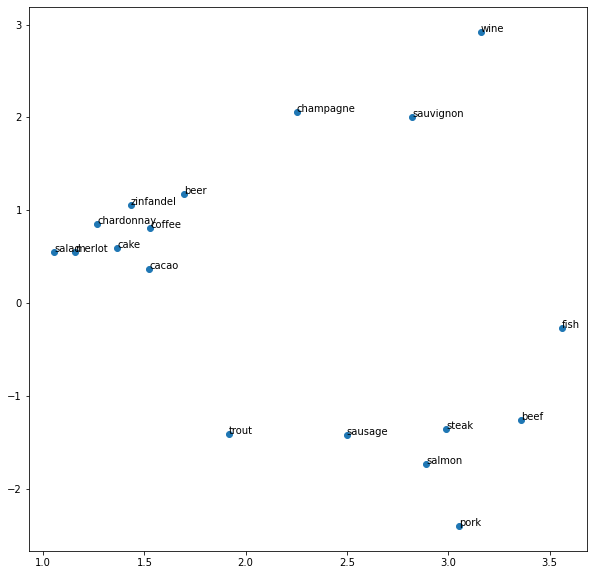

In [17]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [18]:
import gensim.downloader as api
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [19]:
pretrained = api.load('word2vec-google-news-300')  

In [20]:
pretrained.most_similar('cheese')

[('cheeses', 0.7789000272750854),
 ('cheddar', 0.7627596855163574),
 ('goat_cheese', 0.7297402620315552),
 ('Cheese', 0.7286962270736694),
 ('cheddar_cheese', 0.7255136966705322),
 ('Cheddar_cheese', 0.6943709254264832),
 ('mozzarella', 0.6805710196495056),
 ('cheddar_cheeses', 0.6694672703742981),
 ('Camembert', 0.6623162031173706),
 ('gruyere', 0.6615148782730103)]

In [21]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

[('woman', 0.7609435319900513),
 ('girl', 0.6139993667602539),
 ('teenage_girl', 0.6040961742401123),
 ('teenager', 0.5825759172439575),
 ('lady', 0.5752554535865784),
 ('boy', 0.5077577829360962),
 ('policewoman', 0.5066847205162048),
 ('schoolgirl', 0.5052095651626587),
 ('blonde', 0.48696190118789673),
 ('person', 0.48637545108795166)]

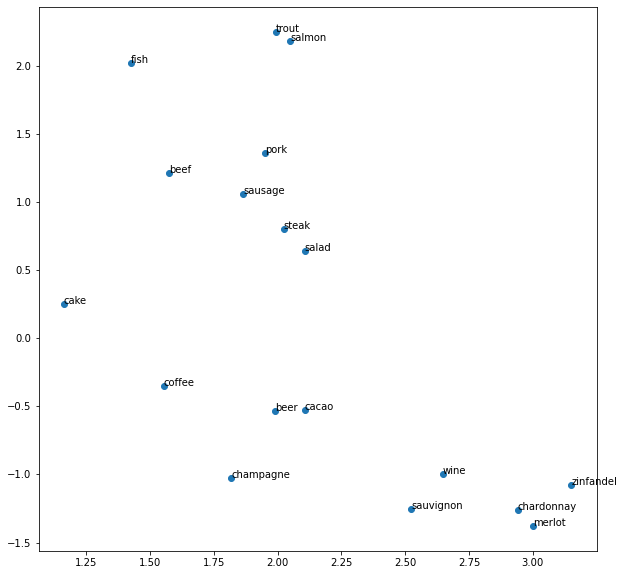

In [22]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают